In [24]:
import os
from os.path import expanduser
import socket
import sys
import glob

# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#########################################

In [25]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

import xarray as xr
import pandas as pd

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

In [26]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'mixlay'

first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [27]:
dates = pd.date_range('1985', freq="M", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates
#data.time.data = dates

In [28]:
data

<xarray.Dataset>
Dimensions:  (nod2d: 753179, time: 372)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-31 1985-02-28 ... 2015-12-31
Dimensions without coordinates: nod2d
Data variables:
    mixlay   (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
Attributes:
    description:  mixed layer thickness
    history:      Created Wed Dec  9 13:29:42 2020

In [29]:
ANPP_sel = data.mixlay.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
ANPP_sel = ANPP_sel.compute()

In [30]:
din_march_mean = ANPP_sel[data['time.month']==3].mean(dim='time')
din_march_mean = din_march_mean.compute()
din_sept_mean = ANPP_sel[data['time.month']==9].mean(dim='time')
din_sept_mean = din_sept_mean.compute()

In [31]:
din_march = ANPP_sel[data['time.month']==3]
din_sept = ANPP_sel[data['time.month']==9]
din_march = din_march.compute()
din_sept = din_sept.compute()

In [32]:
pf = np.polyfit(years, din_march, 1)
din_march_trend = pf[0]
pf = np.polyfit(years, din_sept, 1)
din_sept_trend = pf[0]

In [33]:
import pyfesom as pf

In [34]:
data, elem_no_nan = pf.get_data(din_march_trend,mesh,0)

data2=np.copy(data)
data2 = data2
print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.mean(data2)
print 'Max and min: ',np.max(data2),np.min(data2)

For depth 0 model level -0.0 will be used
Number of nans in tracer:  0
Number of inf in tracer:  0
Mean of surface:  -0.3396131448081887
Max and min:  57.136273187205745 -90.26991118154103


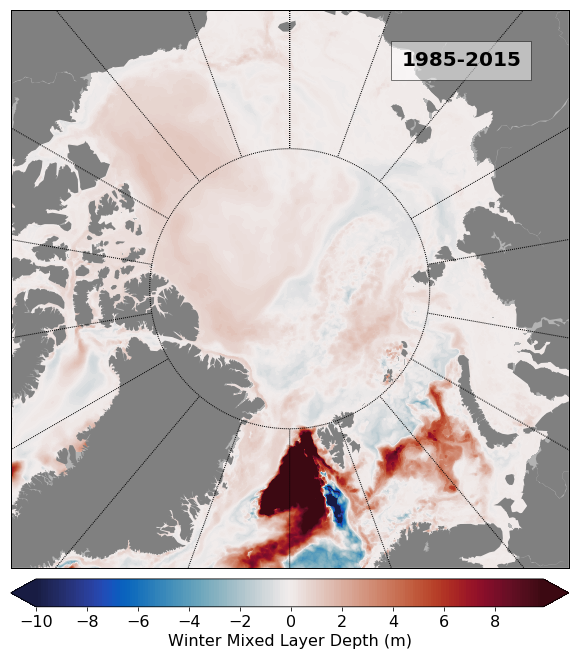

In [35]:
contours = np.arange(-10, 10, .1)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')

#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2 , levels=contours, cmap=cmap.cm.balance, extend='both')

plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

label = 'Winter Mixed Layer Depth (m)'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(wd_path+'figures/'+runid+'/trend/MLDW.png', dpi = 200, bbox_inches='tight')
plt.show()

In [36]:
din_sept_trend[din_sept_trend == 0] = np.nan

data, elem_no_nan = pf.get_data(din_sept_trend,mesh,0)

data2=np.copy(data)
data2 = data2

print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.nanmean(data2)
print 'Max and min: ',np.nanmax(data2),np.nanmin(data2)

For depth 0 model level -0.0 will be used
Number of nans in tracer:  0
Number of inf in tracer:  0
Mean of surface:  -0.14964826424229916
Max and min:  8.62540700358706 -169.24684459624376


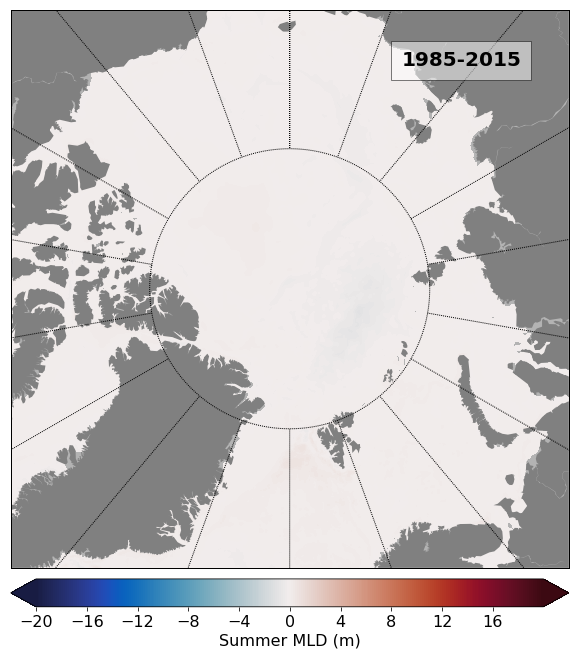

In [37]:
contours = np.arange(-20, 20, .01)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')

#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2, levels=contours, cmap=cmap.cm.balance, extend='both')

plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

label = 'Summer MLD (m)'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(wd_path+'figures/'+runid+'/trend/MLDS.png', dpi = 200, bbox_inches='tight')
plt.show()

In [38]:
data, elem_no_nan = pf.get_data(din_march_mean,mesh,0)

data2=np.copy(data)
data2 = data2

print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.mean(data2)
print 'Max and min: ',np.max(data2),np.min(data2)

For depth 0 model level -0.0 will be used
Number of nans in tracer:  0
Number of inf in tracer:  0
Mean of surface:  120.77430731734407
Max and min:  2339.2381887128277 10.08830064342868


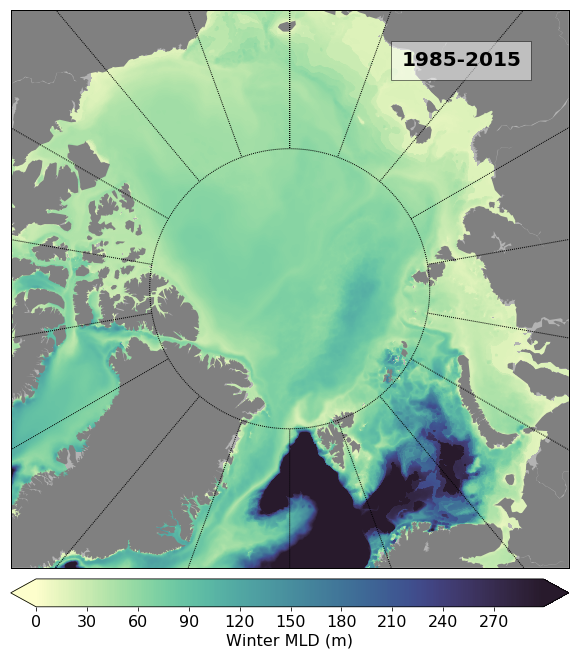

In [39]:
contours = np.arange(0, 300, 1)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')

#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2 , levels=contours, cmap=cmap.cm.deep, extend='both')

plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

label = 'Winter MLD (m)'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(wd_path+'figures/'+runid+'/meanstate/MLDW.png', dpi = 200, bbox_inches='tight')
plt.show()

In [40]:
data, elem_no_nan = pf.get_data(din_sept_mean,mesh,0)

data2=np.copy(data)
data2 = data2

print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
print 'Mean of surface: ',np.mean(data2)
print 'Max and min: ',np.max(data2),np.min(data2)

For depth 0 model level -0.0 will be used
Number of nans in tracer:  0
Number of inf in tracer:  0
Mean of surface:  33.496130895553485
Max and min:  3398.565702376827 10.094817038505308


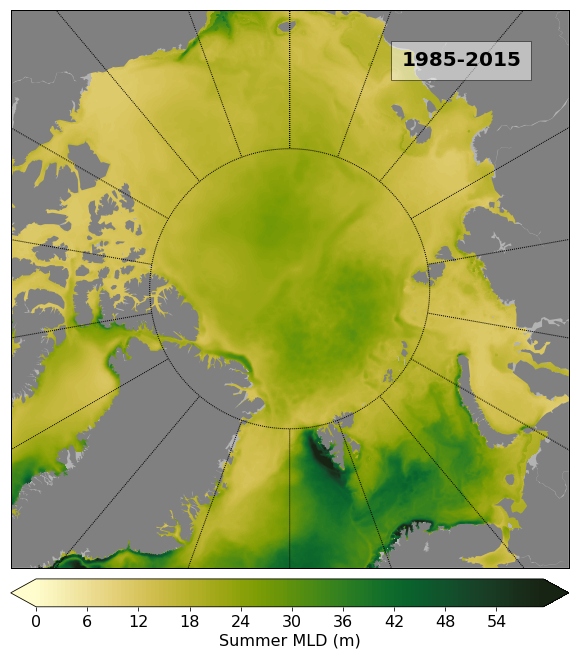

In [41]:
contours = np.arange(0, 60, .5)

fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.suptitle('Density (kg m$^{-3}$)')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)

m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
#map.drawcoastlines()
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')

#eps=(contours.max()-contours.min())/100.
#data2[data2<=contours.min()]=contours.min()+eps
#data2[data2>=contours.max()]=contours.max()-eps

im=plt.tricontourf(x, y, elem_no_nan, data2 , levels=contours, cmap=cmap.cm.speed, extend='both')

plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
                     fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

label = 'Summer MLD (m)'
#plt.title(year)
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(wd_path+'figures/'+runid+'/meanstate/MLDS.png', dpi = 200, bbox_inches='tight')
plt.show()